# DATA PREPARATION
We need to format the suc3.0 data, which exist in an xml tree, in such a way that ALBERT can accept it.

Because of my familiarity with dataframes, I'll begin by converting the xml tree into a pandas dataframe


I'd recommend this link for an easy read on how to use BERT for NER, which should be a good enough paralell for ALBERT
https://www.vamvas.ch/bert-for-ner/

In [1]:
import pandas as pd
import seaborn as sns
import xml.etree.ElementTree as et 
import matplotlib.pyplot as plt
import numpy as np

### Setup

In [2]:
# The attributes at each level of the corpus

TEXT_attributes = {
 'text_blingbring': '|',
 'text_id': '|',
 'text_lix': '|',
 'text_nk': '|',
 'text_ovix': '|',
 'text_swefn': '|',
 'text_index': 0}

SENTENCE_attributes = {
 'sentence__geocontext': '|',
 'sentence_id': '|',
 'sentence_index': 0}

WORD_attributes = {
 'word_blingbring': '|',
 'word_complemgram': '|',
 'word_compwf': '|',
 'word_dephead': '|',
 'word_deprel': '|',
 'word_lemma': '|:|',
 'word_lex': '|',
 'word_msd': '|',
 'word_pos': '|',
 'word_prefix': '|',
 'word_ref': '|',
 'word_sense': '|',
 'word_suffix': '|',
 'word_swefn': '|',
 'word_ex': '|',
 'word_name': '|',
 'word_subtype': '|',
 'word_type': '|',
 'word_index': 0}

# A dict containing all attributes associated with a single word, increading higher-level ones
WORD_LEVEL_MASTER_DICT = {}
WORD_LEVEL_MASTER_DICT.update(TEXT_attributes)
WORD_LEVEL_MASTER_DICT.update(SENTENCE_attributes)
WORD_LEVEL_MASTER_DICT.update(WORD_attributes)

In [3]:
"""
Some tags/dictionaries have a conflicting namespace for the attributes
This function takes the attributes and adds a prefix to the keynames, to make sure nothing overwrites anything else
Returns the same dict but with updated key names
"""
def rename_attributes(dictionary, prefix):
    new_dict = {}
    for key in dictionary.attrib:
        value = dictionary.get(key)
        new_attrib_name = prefix + "_" + key
        new_dict.update({new_attrib_name:value})
        
    return new_dict

### Convert XML to Dataframe

In [4]:
#Create a tree
xtree = et.parse("../data/suc3.xml")

#Get its root element
suc3 = xtree.getroot()

#Get all children - the texts that we will extract words from
texts = suc3.getchildren()

text_index = 0
sentence_index = 0
word_index = 0


#Create a list of datapoints. Each datapoint will be a word with all the attributes of the word itself, the attributes of the sentence it is part of, and the attributes of the text it is part of.
datapoints = []

# Loop over the texts in the corpus...
for text in texts:
    #Assign an index based on the order it appears in the corpus
    text_index = text_index + 1
    
    # Create a dict of attributes that won't cause a namespace conflict
    text_attributes = rename_attributes(text, 'text')
    
    #Add the index as an attribute
    text_attributes.update({"text_index": text_index})
    
    #Get all the sentences that make up this text
    sentences = text.getchildren()  
    
    for sentence in sentences:
        sentence_index = sentence_index + 1

        sentence_attributes = rename_attributes(sentence, 'sentence')
        sentence_attributes.update({"sentence_index": sentence_index})
   
        words = sentence.getchildren()
        
        for word in words:
            word_index = word_index + 1
            
            
            #For words, there are multiple kinds of attributes depending on the kind of word.
            # WORD_attributes is simply a list of all these attributes joined into one.
            word_attributes = WORD_attributes.copy()
            word_attributes.update({"word_index": word_index})
            
            attributes = rename_attributes(word, 'word')
            
            if word.tag == 'ne':
                attributes.update({"word_tag": "ne"})
            else:
                attributes.update({"word_tag": "w"})
                
                #If it's not a named entity, the text is not stored as an attribute but actual text. We treat it as an attribute for coherence
                attributes.update({"word_name": word.text})
                
            word_attributes.update(attributes)
            
            #Copy the master dict and fill it in with all the information we've extracted from the three loops
            WORD_LEVEL_DICT = WORD_LEVEL_MASTER_DICT.copy()
            
            WORD_LEVEL_DICT.update(text_attributes)
            WORD_LEVEL_DICT.update(sentence_attributes)
            WORD_LEVEL_DICT.update(word_attributes)
            
            datapoints.append(WORD_LEVEL_DICT)
                
print("Done")

/home/vic/git/thesis/.thesis/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  
/home/vic/git/thesis/.thesis/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
/home/vic/git/thesis/.thesis/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


Done


## Replace | tokens with NaN

In [128]:
# Having extracted all words and their associated information, let's convert it into a dataframe
df = pd.DataFrame(datapoints)

#Blingbring looks less interesting
df = df.drop(columns={'text_blingbring'})

#Replace the | with None
df = df.replace({'|': np.nan})
df.head(1)

NameError: name 'datapoints' is not defined

In [139]:
# Pickle the data
#df.to_pickle('../data/suc3_dataframe')
df = pd.read_pickle('../data/suc3_dataframe')

## Extract only the parts relevant for NER with ALBERT

In [140]:
#Starting out, I wasn't certain which fields I was going to need, so I grabbed them all.
#Now we narrow things down
data = df[['sentence_index', 'word_name', 'word_pos', 'word_type', 'word_subtype']]
data.head(5)

,sentence_index,word_name,word_pos,word_type,word_subtype
0,1,I,PP,NaN,NaN
1,1,sin,PS,NaN,NaN
2,1,första,RO,NaN,NaN
3,1,reaktion,NN,NaN,NaN
4,1,på,PP,NaN,NaN


## Replace the Nan type of non-entities with O

In [142]:
# The example uses O instaed of Nan, so we follow them
data[['word_type']] = data[['word_type']].replace(np.nan,'O')
data.head(5)

/home/vic/git/thesis/.thesis/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,sentence_index,word_name,word_pos,word_type,word_subtype
0,1,I,PP,O,NaN
1,1,sin,PS,O,NaN
2,1,första,RO,O,NaN
3,1,reaktion,NN,O,NaN
4,1,på,PP,O,NaN


## Switch to wordpiece representation of words using the albert tokenizer

Wordpiece segmentation has some advantages. Even when a model is pretrained and has a good starting point from transfer learning, some words are just too rare to represent correctly.
Wordpiece segmentation breaks unknown words down into smaller subparts

In [143]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("KB/albert-base-swedish-cased-alpha")

#An example of wordpiece segmentation. The whole word might be unknown, but splitting the word into known parts may allow the model to leverage its understanding anyway.
tokenizer.tokenize('Sovjetledarens')

['▁Sovjet', 'led', 'arens']

In [144]:
# Do it for all the data. This takes a while.
# Each word gets represented as a list of the parts it was split into
data['wordpiece'] = data.apply(lambda x: tokenizer.tokenize(x.word_name), axis = 1)

/home/vic/git/thesis/.thesis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Switch to BIO representation of labels

In [145]:
def generate_bio_labels(dataframe_row):
    """
    Switch from single-word single-label to word-piece -bio-piece-labels
    This is done by, for each word, taking the list of subwords it was split into, and matching labels to that.
    We will unravel the lists later
    """
    length_of_split = len(dataframe_row.wordpiece)
    current_tag = dataframe_row.word_type

    labelpiece = []

    #The first part of the split words gets tagged with an "B-" for beginning
    labelpiece.append("B-" + current_tag)

    for i in range(1, length_of_split):   
        #The rest of the parts get tagged with an "I-" for intermediate
        labelpiece.append("I-" + current_tag)

    return labelpiece

In [146]:
#Apply the above function to all the data
data['labelpiece'] = data.apply(lambda x: generate_bio_labels(x), axis = 1)
data.head(20)

/home/vic/git/thesis/.thesis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,sentence_index,word_name,word_pos,word_type,word_subtype,wordpiece,labelpiece
0,1,I,PP,O,NaN,[▁I],[B-O]
1,1,sin,PS,O,NaN,[▁sin],[B-O]
2,1,första,RO,O,NaN,[▁första],[B-O]
3,1,reaktion,NN,O,NaN,[▁reaktion],[B-O]
4,1,på,PP,O,NaN,[▁på],[B-O]
5,1,Sovjetledarens,NN,O,NaN,"[▁Sovjet, led, arens]","[B-O, I-O, I-O]"
6,1,varningar,NN,O,NaN,[▁varningar],[B-O]
7,1,deklarerade,VB,O,NaN,[▁deklarerade],[B-O]
8,1,Litauens,NaN,LOC,PPL,"[▁Lita, uens]","[B-LOC, I-LOC]"
9,1,president,NN,O,NaN,[▁president],[B-O]


## Delete all \N in the data

In [147]:
# We have obsereved errors caused by the word name \n in the data, so we ignore all those rows
rows_with_errors = data[data['word_name'] == '\n'].shape[0]
total_rows = data.shape[0]
print(f"Dropping all tokens consiting of '/\ n' as these are incorrectly tagged. We lose {100*rows_with_errors/total_rows} percent of tokens this way")



Dropping all tokens consiting of '/\ n' as these are incorrectly tagged. We lose 0.7316278455374048 percent of tokens this way


In [148]:
data[data['word_name'] == '\n']

,sentence_index,word_name,word_pos,word_type,word_subtype,wordpiece,labelpiece
118,8,\n,NaN,person,NaN,[],[B-person]
364,22,\n,NaN,inst,NaN,[],[B-inst]
374,22,\n,NaN,inst,NaN,[],[B-inst]
679,37,\n,NaN,inst,NaN,[],[B-inst]
932,55,\n,NaN,person,NaN,[],[B-person]
...,...,...,...,...,...,...,...
1134618,74167,\n,NaN,person,NaN,[],[B-person]
1134779,74182,\n,NaN,person,NaN,[],[B-person]
1134875,74192,\n,NaN,person,NaN,[],[B-person]
1134920,74197,\n,NaN,person,NaN,[],[B-person]


In [ ]:
data = data[data['word_name'] != '\n']

In [137]:
# Let's have a look at a random sentence
data[data['sentence_index'] == 22]

,sentence_index,word_name,word_pos,word_type,word_subtype,wordpiece,labelpiece
361,22,En,DT,O,NaN,[▁En],[B-O]
362,22,talesman,NN,O,NaN,[▁talesman],[B-O]
363,22,vid,PP,O,NaN,[▁vid],[B-O]
365,22,presscenter,NN,O,NaN,"[▁press, center]","[B-O, I-O]"
366,22,i,PP,O,NaN,[▁i],[B-O]
367,22,Vilnius,NaN,LOC,PPL,"[▁Vil, nius]","[B-LOC, I-LOC]"
368,22,bekräftade,VB,O,NaN,[▁bekräftade],[B-O]
369,22,på söndagskvällen,NaN,TME,DAT,"[▁på, ▁söndagskvällen]","[B-TME, I-TME]"
370,22,i,PP,O,NaN,[▁i],[B-O]
371,22,ett,DT,O,NaN,[▁ett],[B-O]


## Group tokens and labels by sentence index. Add special tokens
The special tokens are [CLS] and [SEP], used as the very first and last token in a sentence. [CLS], token1, token2... tokenn, [SEP]

Their use seem to be limited in NER - CLS for example will be used to store an embedding for the whole sentence - but let's add them anyway since everyone else does.

In [124]:
# It seems we're only gonna need the wordpieces and labelpieces
subset = data[['sentence_index','wordpiece', 'labelpiece']].copy()

#Group by sentence
sentence_groupings = subset.groupby('sentence_index')

In [125]:
sentence_groups = []

#Get each group and put it into a list instead of a dict, for my own convenience
for sentence_index in sentence_groupings.groups.keys():
    # Get the data
    sentence_group = sentence_groupings.get_group(sentence_index)
    sentence_groups.append(sentence_group)

In [126]:
#We obtain one element for each sentence. This element is the word-piece sentence
#And of course, a corresponding label
# This takes a while
wordpiece_sentences = []
wordpiece_labels = []

for sentence in sentence_groups:

    tokenized_sentence = []
    tokenized_labels = []
    
    #Add CLS token
    tokenized_sentence.append('[CLS]')
    tokenized_labels.append('[CLS]')

    for word in range(sentence.shape[0]):
        row = sentence.iloc[word]
        tokenized_labels.extend(row.labelpiece)
        tokenized_sentence.extend(row.wordpiece)
    
    #Add SEP token
    tokenized_sentence.append('[SEP]')
    tokenized_labels.append('[SEP]')
    
    wordpiece_sentences.append(tokenized_sentence)
    wordpiece_labels.append(tokenized_labels)


KeyboardInterrupt: 

### check for errors

In [ ]:
# Count the length of all sequences and corresponding labels, they should match
error_sentences = []
for i in range(len(wordpiece_labels)):
    labelcount = len(wordpiece_labels[i])
    sentencecount = len(wordpiece_sentences[i])
    if labelcount != sentencecount:
        error_sentences.append(i)
        

print(f"There are length errors in {len(error_sentences)/len(wordpiece_labels)} percent of sentences")

In [ ]:
def look_at_error_index(index, error_sentences):
    sentence_to_look_at = index
    error_index = error_sentences[sentence_to_look_at]

    print(wordpiece_sentences[error_index])
    print(wordpiece_labels[error_index])
    # What is actually wrong?
    for i in range(len(wordpiece_sentences[error_index])):
        print(wordpiece_sentences[error_index][i] + " : " + wordpiece_labels[error_index][i])

    #Look at the original sentences
    data[data['sentence_index'] == error_index +1]


In [20]:
# Notes on observed errors
# \n has wordtype person (sentence 55). We go back to fix that

## Convert to dataframes, store for later use

In [ ]:
# Move to a dataframe, since those pleas me
wordpiece_sentences_df = pd.DataFrame(wordpiece_sentences)
wordpiece_labels_df = pd.DataFrame(wordpiece_labels)

In [ ]:
# Store them for later use
wordpiece_sentences_df.to_pickle('../data/wordpiece_sentences_df')
wordpiece_labels_df.to_pickle('../data/wordpiece_labels_df')

In [ ]:
import pandas as pd
sentences = pd.read_pickle('../data/wordpiece_sentences_df')
labels = pd.read_pickle('../data/wordpiece_labels_df')

In [ ]:
display(sentences.head())
display(labels.head())

## Replace None with \<pad\>


In [ ]:
# The tokenizer can't deal with None. We replace it with '<pad>', which the albert tokenizer encodes as padding by encoding it as 0
# This will mean that the albert model will ignore these items, which is what we want
print(tokenizer.encode('<pad>'))
sentences.fillna('<pad>', inplace=True)
labels.fillna('<pad>', inplace=True)

## Expand tokenizer vocabulary to be able to deal with our tags
The tags aren't native to swedish ner - the model won't have a representation for B-PER for example.

So we add those manually

In [ ]:
# Grab all the tags we've created
label_set = set()
for column in labels.columns:
    unique_labels = labels[column].unique()
    for label in unique_labels:
        label_set.add(label)
label_list = list(label_set)

print(f"We're working with labels {label_list}")

In [ ]:
print("Testing how the tokenizer encodes our labels right now")
encoded = tokenizer.encode(label_list, add_special_tokens=False)
print(f"Encoded version of labels with current tokenizer {encoded}")
decoded = tokenizer.decode(encoded)
print(f"Decoded version of labels with current tokenizer {decoded}")
print("Yeah that's not gonna work")

In [ ]:
#Add them
tokenizer.add_tokens(label_list)
print("Testing how the tokenizer encodes our labels right now")
encoded = tokenizer.encode(label_list, add_special_tokens=False)
print(f"Encoded version of labels with current tokenizer {encoded}")
decoded = tokenizer.decode(encoded)
print(f"Decoded version of labels with current tokenizer {decoded}")
print("Yeah that's  gonna work")


In [ ]:
import numpy as np
# Let's save the labels as well
np.save('../data/label_list', label_list)

# An important note
Adjusting the vocabulary of the tokenizer does not translate to the albert model being able to deal with that, we need to tell the model that we've adjusted the amount of embeddings with

model.resize_token_embeddings(len(tokenizer))

After updating it

## Check how the conversion to integers looks right now
Integer conversion is needed because the model won't work with charcters - it works with numbers.

So we want each token to be represented by an id

In [ ]:
def encode_without_special_symbol(token):
    """
    I'm not savy enough to know how to apply the function with only some arguments in the pandas mapping.
    I"m sure there is a way.
    But this is fast
    
    Encodes a single token without special tokens added
    """
    return tokenizer.encode(token, add_special_tokens=False)

### It seems like some tokens are split into multiple tokens. Bother, let's have a look at why that is.

In [31]:
tokenizer.encode('sakademin')

[2, 783, 85, 625, 3]

In [32]:
tokenizer.decode([783, 85, 625])

'sakademin'

In [33]:
tokenizer.decode([783, 85])

'sakade'

In [34]:
tokenizer.decode([625])

'min'

Okay, so apparently the encode version isn't the best one, it actually performs tokenization by itself. Since I've already split into tokens - though apparently not the same way as this function would - I have another one to use


In [35]:
tokenizer.convert_tokens_to_ids('sakademin')

31365

In [ ]:
# Yes, this looks better.
# The conversion takes a while though
sentences = sentences.applymap(tokenizer.convert_tokens_to_ids)
labels = labels.applymap(tokenizer.convert_tokens_to_ids)


### Create attention masks
Attention is 0 if the token is entirely unimportant. This is useful for dealing with padding, and is part of the input to the albert model

In [ ]:
def attentionmapping(x):
    if x != 0:
        return 1
    else:
        return 0

In [ ]:
attention = sentences.applymap(attentionmapping)

In [39]:
# Store them for later use
#sentences.to_pickle('../data/sentence_ints')
#labels.to_pickle('../data/label_ints')
#attention.to_pickle('../data/attention_ints')

In [1]:
# Took a break, don't want to run through all the previous code
import pandas as pd
import numpy as np
from transformers import AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
def restart():
    tokenizer = AutoTokenizer.from_pretrained("KB/albert-base-swedish-cased-alpha")
    sentences = np.load('../data/sentence_ints.npy')
    labels = np.load('../data/label_ints.npy')
    attentions = np.load('../data/attention_ints.npy')
    label_list = np.load('../data/label_list.npy')
    return tokenizer, sentences, labels, attentions, label_list
tokenizer, sentences, labels, attentions, label_list = restart()

tokenizer.add_tokens(label_list.tolist())

30

(74165, 100)

## Check sentence lengths
Right now we're working with a sentence length such that each sentence fits. But having a 400+ dimensional vector will take some computing power, it might be worth reducing it


In [19]:
s = pd.read_pickle('../data/wordpiece_sentences_df')
lengthcount = s.count(axis = 1)

In [95]:
pd.DataFrame(lengthcount).describe()

,0
count,74165.000000
mean,21.725329
std,13.056655
min,3.000000
25%,13.000000
50%,19.000000
75%,28.000000
max,404.000000


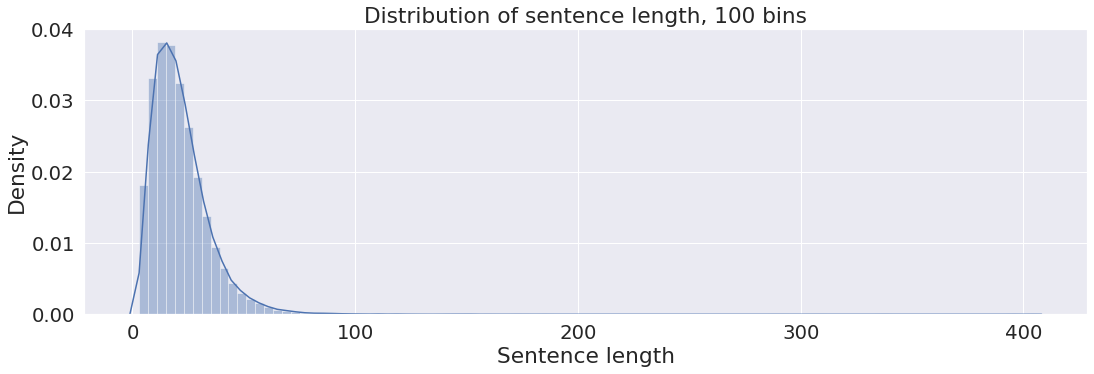

In [114]:
sns.set(font_scale=1.8)
fig, ax = plt.subplots(figsize = (15,5))
#divide by 100 to get percent instead of fixing the axis. cheatcode!
sns.distplot(lengthcount, bins=100, ax = ax)
ax.set_xlabel('Sentence length')
ax.set_ylabel('Density')
ax.set_title('Distribution of sentence length, 100 bins')
fig.tight_layout(pad=0)
plt.savefig("../data/assets/senLength.png")

plt.show()


In [106]:
ax.set_yticklabels(labels= ax.get_yticklabels())

[Text(0, 0.0, '0.00'),
 Text(0, 0.01, '0.01'),
 Text(0, 0.02, '0.02'),
 Text(0, 0.03, '0.03'),
 Text(0, 0.04, '0.04'),
 Text(0, 0.05, '0.05')]

In [98]:
z = pd.DataFrame(lengthcount)
more_than_100 = 100 * z[z[0] > 100].shape[0]/z.shape[0]

In [99]:
print(f"{more_than_100} percent of items are longer than 100 words")

0.10382255781028787 percent of items are longer than 100 words


### Only 0.1% of the sentences are longer than 100 words, so we switch the cutoff-point for the matrices at 100 columns instead of 404. A huge dimensionality reduction
I'll slice and save them as numpy arrays instead.

In [45]:
sentences = sentences.values[:,:100]
labels = labels.values[:,:100]
attentions = attentions.values[:,:100]

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
# Store them for later use
#np.save('../data/sentence_ints', sentences)
#np.save('../data/label_ints', labels)
#np.save('../data/attention_ints', attentions)

## Dataset Named Entity Breakdown

In [ ]:
df = pd.read_pickle('../data/suc3_dataframe')

In [ ]:
entities = df[df['word_tag'] == 'ne']
entities

## Unique labels in type and subtype

In [ ]:
types = entities['word_type'].unique()
print(types.shape[0])
types

In [ ]:
subtypes = entities['word_subtype'].unique()
print(subtypes.shape[0])
subtypes

## Examples of subclass effect

In [ ]:
ex = entities[entities['word_type'] =='PRS'][['word_name', 'word_type', 'word_subtype']]
print(f"Unique subtypes = {ex['word_subtype'].unique()}")
print()
print(read[ex['word_subtype'] == 'HUM'].iloc[0])
print()

print(read[ex['word_subtype'] == 'MTH'].loc[191707])
print()

print(read[ex['word_subtype'] == 'ANM'].iloc[0])
